In [1]:
#import libraries
import os
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Input, concatenate, Flatten, Dense, Attention, Multiply, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2024-04-08 18:18:19.242324: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Data preparation
dataset_dir= 'TNB_split'
input_shape=(224, 224, 3)
batch_size=16
num_classes=5

In [3]:
#Data augmentation
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen=ImageDataGenerator(
    rescale=1./255)

In [4]:
#Generate the train dataset, validation dataset and test dataset
train_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical', #skin has two classes: benign and malignant
    )

validation_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical', #skin has two classes: benign and malignant
    )

test_generator=test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical', #skin has two classes: benign and malignant
    )

Found 2562 images belonging to 5 classes.
Found 369 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [5]:
#Ensemble Model using pre-trained model

# Load pre-trained models
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the pre-trained models
for layer in resnet_model.layers:
    layer.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

2024-04-08 18:18:21.307095: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-04-08 18:18:21.333304: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:e3:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.55GHz coreCount: 128 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 938.86GiB/s
2024-04-08 18:18:21.333336: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-04-08 18:18:21.337367: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-04-08 18:18:21.337442: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-04-08 18:18:21.338785: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

In [6]:
# 假设 resnet_model 和 vgg_model 是你的预训练模型

input_layer = Input(shape=(224, 224, 3))
resnet_features = resnet_model(input_layer)
vgg_features = vgg_model(input_layer)

merged = concatenate([resnet_features, vgg_features])
flatten = Flatten()(merged)
dense1 = Dense(512, activation='relu')(flatten)
output_layer = Dense(5, activation='softmax')(dense1)

ensemble_model = Model(inputs=input_layer, outputs=output_layer)


ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 7, 7, 2048)   23587712    input_3[0][0]                    
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 7, 7, 512)    14714688    input_3[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 7, 7, 2560)   0           resnet50[0][0]                   
                                                                 vgg16[0][0]                  

In [7]:
# Compile and train the ensemble model
ensemble_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
#Train the model
history=ensemble_model.fit(train_generator, batch_size=batch_size, epochs=50, validation_data=(validation_generator), verbose=1)

Epoch 1/50


2024-04-08 18:18:24.647621: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-04-08 18:18:24.647955: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2000000000 Hz
2024-04-08 18:18:40.997739: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-04-08 18:18:41.815557: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2024-04-08 18:18:42.811631: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-04-08 18:18:42.811656: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at /usr/local/cuda-11.2/bin/ptxas
2024-04-08 18:18:42.811755: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: /usr/local/cuda-11.2/bin/ptxas ptxas too old. Falling back to the driver to compile.
Re

  3/161 [..............................] - ETA: 15s - loss: 24.2735 - accuracy: 0.3993 

2024-04-08 18:18:44.045120: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


161/161 [==============================] - 67s 297ms/step - loss: 7.9705 - accuracy: 0.5195 - val_loss: 0.8765 - val_accuracy: 0.6856
Epoch 2/50
161/161 [==============================] - 43s 269ms/step - loss: 0.9026 - accuracy: 0.6826 - val_loss: 0.9698 - val_accuracy: 0.6911
Epoch 3/50
161/161 [==============================] - 44s 270ms/step - loss: 0.8809 - accuracy: 0.6883 - val_loss: 0.8346 - val_accuracy: 0.6992
Epoch 4/50
161/161 [==============================] - 43s 267ms/step - loss: 0.8442 - accuracy: 0.7011 - val_loss: 0.8668 - val_accuracy: 0.6911
Epoch 5/50
161/161 [==============================] - 43s 269ms/step - loss: 0.8122 - accuracy: 0.6997 - val_loss: 0.7742 - val_accuracy: 0.7019
Epoch 6/50
161/161 [==============================] - 43s 269ms/step - loss: 0.8276 - accuracy: 0.7058 - val_loss: 0.7883 - val_accuracy: 0.7127
Epoch 7/50
161/161 [==============================] - 43s 269ms/step - loss: 0.8013 - accuracy: 0.7127 - val_loss: 0.8007 - val_accuracy: 0.6

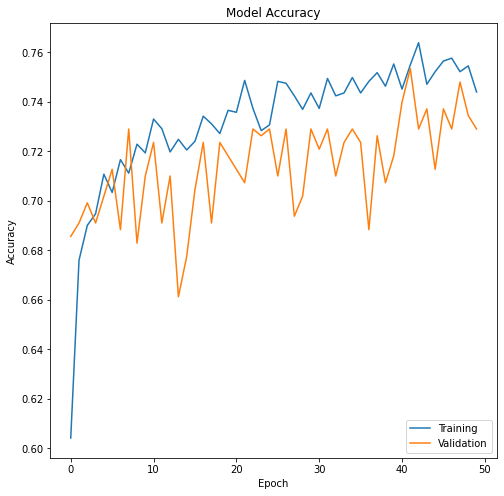

In [9]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

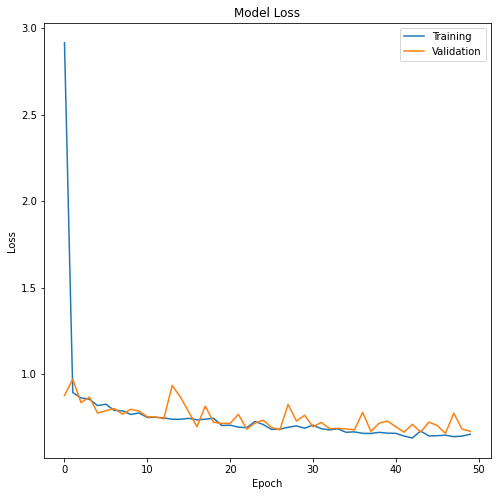

In [10]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [11]:
test_loss, test_accuracy = ensemble_model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

46/46 [==============================] - 5s 105ms/step - loss: 0.6978 - accuracy: 0.7360
Test Loss: 0.6978320479393005
Test Accuracy: 0.7359781265258789


In [12]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc

In [13]:
# Get the prediction results of the model
y_pred = ensemble_model.predict(test_generator)
y_true = test_generator.classes

Confusion Matrix:
[[ 44  14  11   5   0]
 [ 32 136  30   1   0]
 [  8   0 353   0   0]
 [ 12  34   7   5   1]
 [  6  25   1   6   0]]


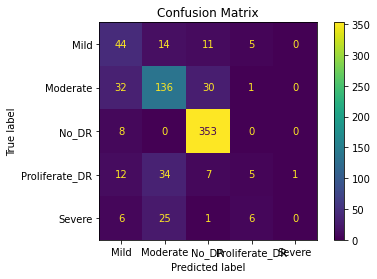

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
# Convert probabilities to categories
y_pred_labels = np.argmax(y_pred, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred_labels)

print("Confusion Matrix:")
print(confusion)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=class_labels)
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

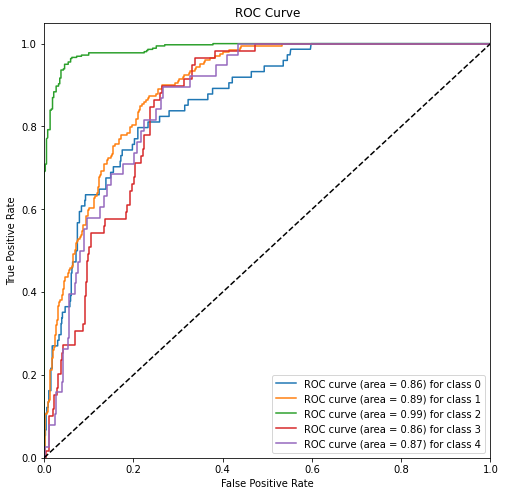

In [16]:
# Plot ROC curve
plt.figure(figsize=(8, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [17]:
# Import necessary libraries
from sklearn.metrics import f1_score

# Assuming y_true and y_pred_labels are defined

# Compute the F1 score (micro)
f1_micro = f1_score(y_true, y_pred_labels, average='micro')
print('F1-score (micro):', f1_micro)

# Compute the F1 score (macro)
f1_macro = f1_score(y_true, y_pred_labels, average='macro')
print('F1-score (macro):', f1_macro)

# Compute the F1 score (weighted)
f1_weighted = f1_score(y_true, y_pred_labels, average='weighted')
print('F1-score (weighted):', f1_weighted)

F1-score (micro): 0.7359781121751026
F1-score (macro): 0.4447081005265458
F1-score (weighted): 0.6996734327567056


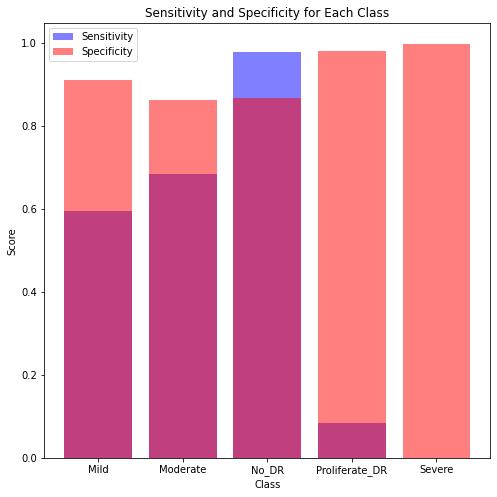

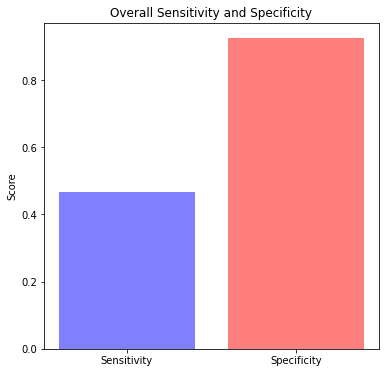

In [18]:
import matplotlib.pyplot as plt

# Initialize variables to store overall sensitivity and specificity
overall_sensitivity = 0
overall_specificity = 0
sensitivity_scores = []
specificity_scores = []

# Loop through each class
for i, class_label in enumerate(class_labels):
    # Extract TP, FP, FN, and TN for the current class
    TP = confusion[i, i]
    FP = sum(confusion[:, i]) - TP
    FN = sum(confusion[i, :]) - TP
    TN = sum(sum(confusion)) - TP - FP - FN
    
    # Compute sensitivity and specificity for the current class
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    # Accumulate sensitivity and specificity for overall calculation
    overall_sensitivity += sensitivity
    overall_specificity += specificity
    
    # Store sensitivity and specificity for current class
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)

# Calculate overall sensitivity and specificity
num_classes = len(class_labels)
overall_sensitivity /= num_classes
overall_specificity /= num_classes

# Plotting sensitivity and specificity for each class
plt.figure(figsize=(8, 8))
plt.bar(range(len(class_labels)), sensitivity_scores, color='b', alpha=0.5, label='Sensitivity')
plt.bar(range(len(class_labels)), specificity_scores, color='r', alpha=0.5, label='Specificity')
plt.xticks(range(len(class_labels)), class_labels)
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Sensitivity and Specificity for Each Class')
plt.legend()
plt.show()

# Plotting overall sensitivity and specificity
plt.figure(figsize=(6, 6))
plt.bar(['Sensitivity', 'Specificity'], [overall_sensitivity, overall_specificity], color=['b', 'r'], alpha=0.5)
plt.ylabel('Score')
plt.title('Overall Sensitivity and Specificity')
plt.show()
